In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import sys
from matplotlib.colors import to_rgba
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/work/ccnr/glover.co/net_design/NetDesign')
import network_design as nd

In [156]:
df_people = pd.read_csv('../../data/social_networks/broadway/broadway_people.csv',index_col=False)

In [157]:
creatives = ['Written','Directed','Lyrics','Book','Music','Original Music','Choreographed','Book adapted']

In [158]:
df_creatives = df_people[df_people.Role.isin(creatives)]

In [159]:
df_shows = pd.read_csv('../../data/social_networks/broadway/broadway_show.csv',index_col=False)

In [160]:
valid_shows = pd.unique(df_shows.Season)[-10:]

In [161]:
df_shows = df_shows[df_shows.Season.isin(valid_shows)]

In [162]:
df_musicals = df_shows[df_shows.Type=='Musical']

In [163]:
df_creatives_10_years = pd.merge(df_musicals,df_creatives,on='Show')
df_creatives_10_years = df_creatives_10_years.replace('Book adapted','Book')
df_creatives_10_years = df_creatives_10_years.replace('Written','Book')
df_creatives_10_years = df_creatives_10_years.replace('Original Music','Music')
persons_with_role = [(x,y,z) for x,y,z in zip(df_creatives_10_years.Person,df_creatives_10_years.Role,df_creatives_10_years.Show)]

/tmp/ipykernel_27271/370580658.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_creatives_10_years = df_creatives_10_years.replace('Book adapted','Book')


In [164]:
g = nx.Graph()
# g.add_nodes_from(pd.unique(persons_with_role))
# g.add_nodes_from(pd.unique(df_creatives_10_years.Show))


In [165]:
persons_with_role_array = np.array(persons_with_role)
[tuple(x) for x in persons_with_role_array[[14,15,16,17,18],:]]

[('Gale Edwards', 'Directed', 'Jesus Christ Superstar'),
 ('Anthony Van Laast', 'Choreographed', 'Jesus Christ Superstar'),
 ('Andrew Lloyd Webber', 'Music', 'Jesus Christ Superstar'),
 ('Tim Rice', 'Lyrics', 'Jesus Christ Superstar'),
 ('Des McAnuff', 'Directed', 'Jesus Christ Superstar')]

In [166]:
np.where(persons_with_role_array[:,2]== 'Caroline, or Change')[0]

array([1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275])

In [167]:
particle_types = np.unique(np.array(persons_with_role)[:,1])
particle_types

array(['Book', 'Choreographed', 'Directed', 'Lyrics', 'Music'],
      dtype='<U87')

In [168]:
from itertools import combinations
for s in np.unique(np.array(persons_with_role)[:,2]):
    # Get people
    people_idx = np.where(persons_with_role_array[:,2] == s)[0]
    people = persons_with_role_array[people_idx,:2]
    pairs = list(combinations([tuple(x) for x in people],2))
    # pairs = [(s,p) for p in people]
    g.add_edges_from(pairs)
# for n in list(g.nodes()):
#     if len(pd.unique(df_creatives_10_years[df_creatives_10_years.Person == n].Role)) > 1:
#         g.remove_node(n)

In [169]:
g.remove_edges_from(nx.selfloop_edges(g))

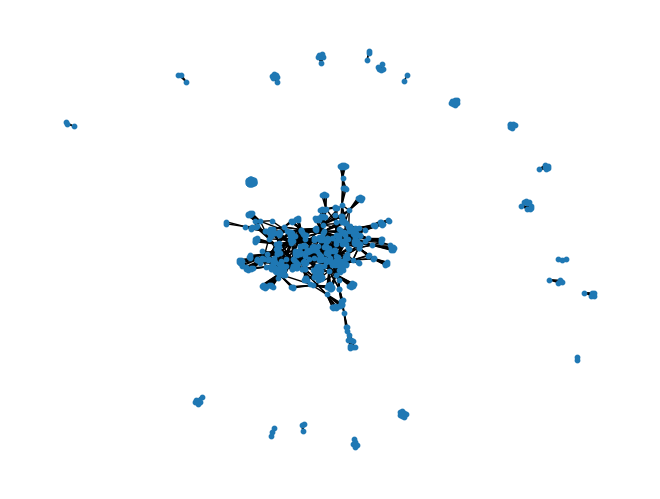

In [170]:
nx.draw(g,node_size=10,width=1)

In [171]:
g.edges()

EdgeView([(('Chazz Palminteri', 'Book'), ('Alan Menken', 'Music')), (('Chazz Palminteri', 'Book'), ('Glenn Slater', 'Lyrics')), (('Chazz Palminteri', 'Book'), ('Robert De Niro', 'Directed')), (('Chazz Palminteri', 'Book'), ('Jerry Zaks', 'Directed')), (('Chazz Palminteri', 'Book'), ('Sergio Trujillo', 'Choreographed')), (('Alan Menken', 'Music'), ('Glenn Slater', 'Lyrics')), (('Alan Menken', 'Music'), ('Robert De Niro', 'Directed')), (('Alan Menken', 'Music'), ('Jerry Zaks', 'Directed')), (('Alan Menken', 'Music'), ('Sergio Trujillo', 'Choreographed')), (('Alan Menken', 'Music'), ('Chad Beguelin', 'Book')), (('Alan Menken', 'Music'), ('Howard Ashman', 'Lyrics')), (('Alan Menken', 'Music'), ('Tim Rice', 'Lyrics')), (('Alan Menken', 'Music'), ('Casey Nicholaw', 'Directed')), (('Alan Menken', 'Music'), ('Casey Nicholaw', 'Choreographed')), (('Alan Menken', 'Music'), ('Janus Cercone', 'Book')), (('Alan Menken', 'Music'), ('Warren Leight', 'Book')), (('Alan Menken', 'Music'), ('Christopher 

In [172]:
h = nx.subgraph(g,sorted(list(nx.connected_components(g)),key=len,reverse=True)[0])

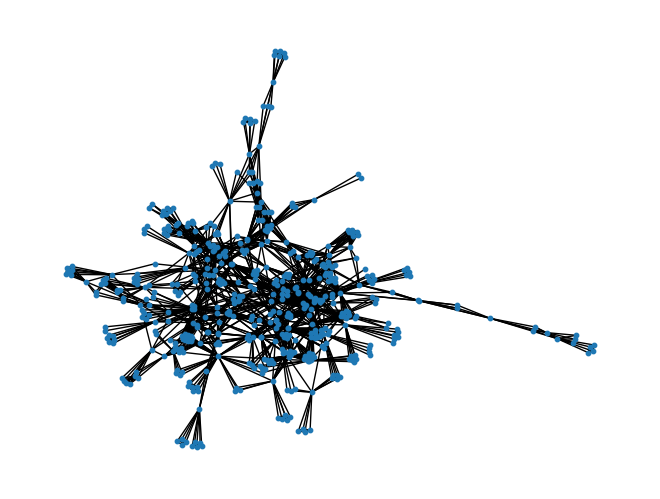

In [173]:
nx.draw(h,node_size=10,width=1)

In [174]:
# Get X
X = np.zeros((g.number_of_nodes(),len(particle_types)))

In [175]:
particle_types

array(['Book', 'Choreographed', 'Directed', 'Lyrics', 'Music'],
      dtype='<U87')

In [176]:
for i, n in enumerate(g.nodes()):
    role = n[1]
    for j, p in enumerate(particle_types[:]):
        if role == p:
            X[i,j] = 1

In [177]:
X

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [178]:
A = nx.adjacency_matrix(g).toarray()

In [179]:
neighbor_labels = A@X

In [180]:
O = np.zeros((len(particle_types),len(particle_types)))
labels = np.argmax(X,axis=1)
for i in range(len(particle_types)):
    for j in range(len(particle_types)):
        node_idx = np.where( labels == i )[0]
        O[i,j] = np.nan_to_num((A@X)[np.where(np.argmax(X,axis=1) == i)[0]].mean(axis=0),0)[j]

In [182]:
# O = nd.extract_O(nx.convert_node_labels_to_integers(h),X)
O = np.round(O)
O

array([[ 1.,  1.,  2.,  1.,  1.],
       [ 2., 13.,  2.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.],
       [ 2.,  1.,  2.,  1.,  2.],
       [ 2.,  1.,  2.,  2.,  1.]])

In [186]:
obj = nd.NetAssembly(X,O,X.sum(axis=0,dtype=int))

In [187]:
obj.run(10000,component=False,link_strength=.2)

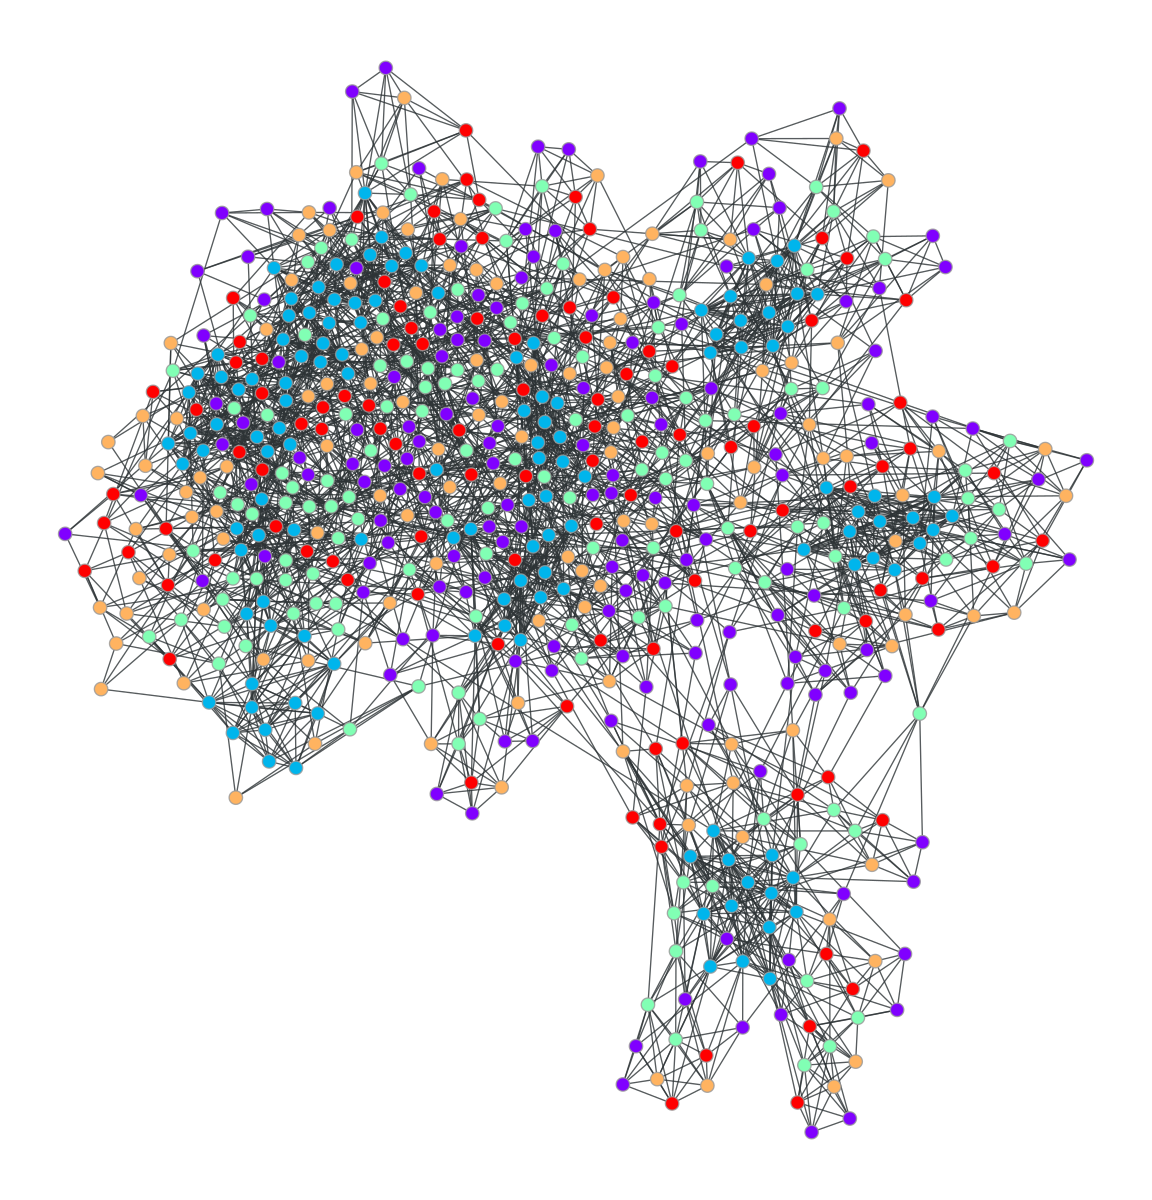

<Figure size 500x500 with 0 Axes>

In [188]:
obj.draw(with_networkx=False)

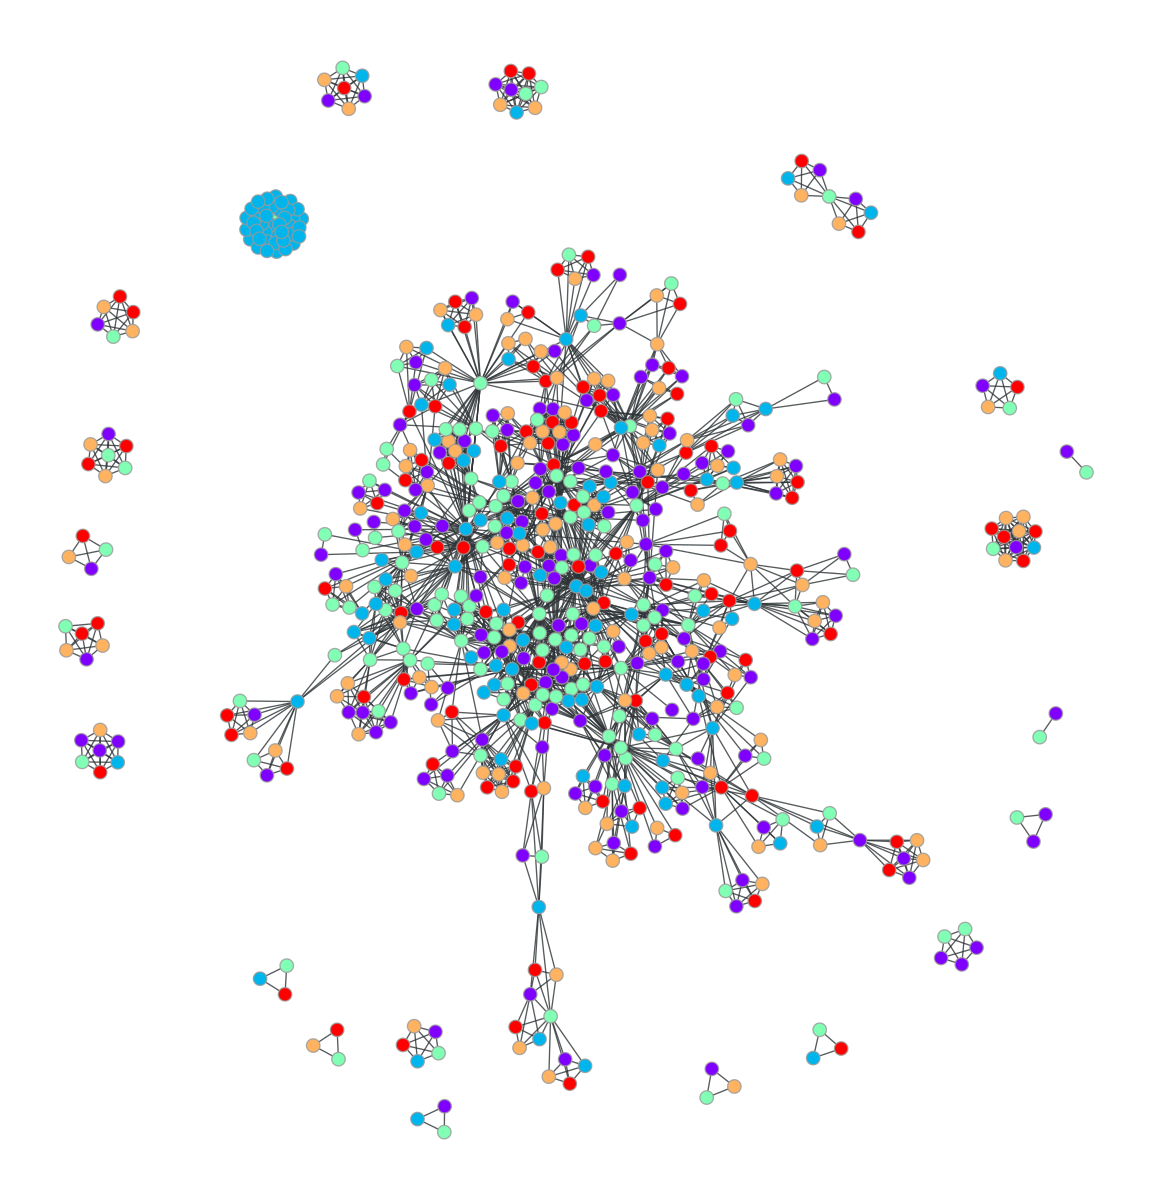

<Figure size 500x500 with 0 Axes>

In [189]:
og_obj = nd.NetAssembly(X,O,X.sum(axis=0,dtype=int))
og_obj.g = g
og_obj.draw(with_networkx=False)

In [6]:
off_broadway_people = pd.read_csv('../../data/offbroadway/offbroadway_persons.txt',delimiter='\t')

In [8]:
off_broadway_credits = pd.read_csv('../../data/offbroadway/offbroadway_credits.txt',delimiter='\t')

In [9]:
off_broadway_credits

,ProductionID,PersonID
0,3e433f44-c5ff-4783-969f-553e3f88fb45,6d85a337-5e36-4489-a687-761a732708b8
1,8c336da9-75d6-403f-893b-42bdb17a8be2,ca1beb9e-0498-4fc0-867c-d6f1f18e066c
2,0f5eb0d1-a196-49c5-b262-8192c9e89e99,ceda8653-8c91-435c-9d43-cb41baa669d4
3,9a2ec473-8364-4849-8735-b96d410b14ba,2968dc2f-7b4a-41c4-afc8-1bd7d0923bc6
4,4a7f4382-5375-4311-a0db-88c88dc1fe4f,8b46bb53-87b3-424b-a13a-1498c6b1e137
...,...,...
141336,f9f86754-da7f-4338-8331-7330718c3dd0,c8f9aee9-5ebc-4715-a549-78a3503c137b
141337,fbfa4ab3-a330-4658-a771-2fa5f1d6e69e,64fac97a-62cd-4de9-bb72-1323c8c8721e
141338,c66bd4b5-1650-40b2-abe1-8a2c62418470,d44f9c91-52e5-4369-9ff4-dfcc710a33db
141339,40bb3d73-6ef8-4a1c-9eec-469f5cfe63ea,00f86326-dabe-4058-9f22-eaf22676f611
